In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.rnn = nn.LSTM(input_dim, hid_dim, n_layers, dropout = dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):

        #src = [src len, batch size, input_dim]
        outputs, (hidden, cell) = self.rnn(src)
        
        # outputs = [src len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]
        
        return hidden, cell



In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim ,input_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.input_dim = input_dim
        
        self.rnn = nn.LSTM(input_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    
    def forward(self, input, hidden, cell):
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]
        # Decoder에서 항상 n directions = 1
        # 따라서 hidden = [n layers, batch size, hid dim]
        # context = [n layers, batch size, hid dim]
        # input = [1, batch size]
        #input = input.unsqueeze(0)
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        # output = [seq len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]
        
        # Decoder에서 항상 seq len = n directions = 1 
        # 한 번에 한 토큰씩만 디코딩하므로 seq len = 1
        # 따라서 output = [1, batch size, hid dim]
        # hidden = [n layers, batch size, hid dim]
        # cell = [n layers, batch size, hid dim]
        
        # prediction = [batch size, output dim]
        prediction = self.fc_out(output.squeeze(0))
        
        return prediction, hidden, cell

In [ ]:
class Seq2Seq(nn.Module):
   def __init__(self, encoder, decoder, device):
       super().__init__()
       
       self.encoder = encoder
       self.decoder = decoder
       self.device = device
       # Encoder와 Decoder의 hidden dim이 같아야 함
       assert encoder.hid_dim == decoder.hid_dim
       # Encoder와 Decoder의 layer 개수가 같아야 함
       assert encoder.n_layers == decoder.n_layers
       
   def forward(self, src, trg, teacher_forcing_ratio=0.5):
       # src = [src len, batch size]
       # trg = [trg len, batch size]
       
       trg_len = trg.shape[0]
       batch_size = trg.shape[1]
       trg_vocab_size = self.decoder.ouput_dim
       
       # decoder 결과를 저장할 텐서
       outputs = torch.zeros(trg_len, batch_size, trg_vocab_size)
       
       # Encoder의 마지막 은닉 상태가 Decoder의 초기 은닉상태로 쓰임
       hidden, cell = self.encoder(src)
       
       # Decoder에 들어갈 첫 input은 <sos> 토큰
       input = trg[0, :]
       
       # target length만큼 반복
       # range(0,trg_len)이 아니라 range(1,trg_len)인 이유 : 0번째 trg는 항상 <sos>라서 그에 대한 output도 항상 0 
       for t in range(1, trg_len):
           output, hidden, cell = self.decoder(input, hidden, cell)
           outputs[t] = output
           
           # random.random() : [0,1] 사이 랜덤한 숫자 
           # 랜덤 숫자가 teacher_forcing_ratio보다 작으면 True니까 teacher_force=1
           teacher_force = random.random() < teacher_forcing_ratio
           
           # 확률 가장 높게 예측한 토큰
           top1 = output.argmax(1) 
           
           # techer_force = 1 = True이면 trg[t]를 아니면 top1을 input으로 사용
           input = trg[t] if teacher_force else top1
       
       return outputs

In [ ]:
input_dim = len(SRC.vocab)
output_dim = len(TRG.vocab)

# Encoder embedding dim
enc_emb_dim = 256
# Decoder embedding dim
dec_emb_dim = 256

hid_dim=512
n_layers=2

enc_dropout = 0.5
dec_dropout=0.5

enc = Encoder(input_dim, enc_emb_dim, hid_dim, n_layers, enc_dropout)
dec = Decoder(output_dim, dec_emb_dim, hid_dim, n_layer, dec_dropout)

model = Seq2Seq(enc, dec, device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uiform_(param.data, -0.08, 0.08)
output = model(src, trg)

model.apply(init_weights)

In [34]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
import gc
import matplotlib.pyplot as plt
import pickle
import torch
from utils.preprocess_utils import *

# load data
time_data = pd.read_csv('data/original/notime_data.txt', sep  = ' ') 
#time_data = df2npy(time_data)


FileNotFoundError: [Errno 2] No such file or directory: 'data/original/notime_data.txt'

In [36]:
nontime_data = pd.read_csv('data/original/nontime_data.txt', sep = ' ')

In [37]:
nontime_data

,HDONG_NM,HDONG_CD,time,tot_pop,age_80U,AREA
0,고산1동,2726067000,evening,32460,0.025970,8881312.38
1,고산1동,2726067000,lunch,32460,0.025970,8881312.38
2,고산1동,2726067000,morning,32460,0.025970,8881312.38
3,고산2동,2726068000,evening,27728,0.031989,24523329.28
4,고산2동,2726068000,lunch,27728,0.031989,24523329.28
...,...,...,...,...,...,...
202,황학동,1114067000,lunch,12609,0.029582,328678.23
203,황학동,1114067000,morning,12609,0.029582,328678.23
204,회현동,1114054000,evening,5296,0.071941,847351.57
205,회현동,1114054000,lunch,5296,0.071941,847351.57


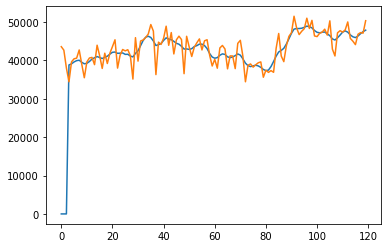

In [31]:
plt.plot(trend_x)
plt.plot(x)

In [28]:
trend_x[-1]

0.0